# No-glue-code

In [1]:
using Pkg
Pkg.activate("..")

  Activating project at `~/Cambdrige`


In [2]:
using Random
using LinearAlgebra
using PyPlot

#What we are tweaking
using Revise
using AdvancedHMC
using Turing

[ Info: Precompiling AdvancedHMC [0bf59076-c3b1-5ca4-86bd-e02cd72cde3d]
[ Info: Precompiling Turing [fce5fe82-541a-59a6-adf8-730c64b5f9a0]


## Model

In [3]:
# Just a simple Neal Funnel
d = 21
@model function funnel()
    θ ~ Normal(0, 3)
    z ~ MvNormal(zeros(d-1), exp(θ)*I)
    x ~ MvNormal(z, I)
end

funnel (generic function with 2 methods)

In [4]:
Random.seed!(1)
(;x) = rand(funnel() | (θ=0,))
funnel_model = funnel() | (;x)

DynamicPPL.Model{typeof(funnel), (), (), (), Tuple{}, Tuple{}, DynamicPPL.ConditionContext{NamedTuple{(:x,), Tuple{Vector{Float64}}}, DynamicPPL.DefaultContext}}(funnel, NamedTuple(), NamedTuple(), ConditionContext((x = [1.2142074831535152, 1.23371919965455, -0.8480146960461767, 0.1600994648479841, 1.9180385508479283, -3.401523464506408, -0.0957684186471088, 0.6734622629464286, -3.2749467689509633, -1.6760091758453226, 1.9567202902549736, 0.1136169088905351, 0.11117896909388916, -0.5373922347882832, -0.12436857036298687, -1.2901071061088532, 1.702584517514787, -0.44460133117954226, 1.0818722439221686, 1.2208011493237483],), DynamicPPL.DefaultContext()))

## Sampling

In [5]:
nadapts=500 
TAP=0.95
nuts = AdvancedHMC.NUTS(nadapts, TAP; init_ϵ=0.1)

AdvancedHMC.NUTS(500, 0.95, 10, 1000.0, 0.1, nothing, Leapfrog, AdvancedHMC.NUTS_kernel, AdvancedHMC.var"#adaptor#32"{Float64}(0.95))

In [6]:
ϵ=0.1
n_leapfrog=20
hmc = AdvancedHMC.HMC(ϵ, n_leapfrog)

AdvancedHMC.HMC(0.1, 20, nothing, Leapfrog, AdvancedHMC.var"#kernel#33"{Int64}(20), AdvancedHMC.Adaptation.NoAdaptation())

In [7]:
n_adapts = 500
TAP = 0.95
λ = 0.1 * 10
#ϵ = 0.1
hmcda = AdvancedHMC.HMCDA(n_adapts, TAP, λ; ϵ = 0.1)

AdvancedHMC.HMCDA(500, 0.95, 1.0, 0.1, nothing, Leapfrog, AdvancedHMC.var"#kernel#35"{Float64}(1.0), AdvancedHMC.var"#adaptor#37"{Float64}(0.95))

In [9]:
nuts_samples = sample(funnel_model, nuts, 5000)

Hell
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World

Sampling:   4%|█▍                                       |  ETA: 0:00:03

World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
Worl

Sampling:  28%|███████████▋                             |  ETA: 0:00:02

World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
Worl

Sampling:  36%|██████████████▌                          |  ETA: 0:00:02

World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
Worl

Sampling:  40%|████████████████▎                        |  ETA: 0:00:02

World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
Worl

Sampling:  44%|██████████████████                       |  ETA: 0:00:02

World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
Worl

Sampling:  50%|████████████████████▎                    |  ETA: 0:00:02

World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
Worl

Sampling:  54%|██████████████████████▍                  |  ETA: 0:00:01

World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
Worl

Sampling:  58%|████████████████████████                 |  ETA: 0:00:01

World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
Worl

Sampling:  64%|██████████████████████████               |  ETA: 0:00:01

World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
Worl

Sampling:  68%|███████████████████████████▉             |  ETA: 0:00:01

World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
Worl

Sampling:  72%|█████████████████████████████▊           |  ETA: 0:00:01

World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
Worl

Sampling:  77%|███████████████████████████████▋         |  ETA: 0:00:01

World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
Worl

Sampling:  82%|█████████████████████████████████▍       |  ETA: 0:00:01

World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
Worl

Sampling:  86%|███████████████████████████████████      |  ETA: 0:00:00

World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
Worl

Sampling:  90%|████████████████████████████████████▉    |  ETA: 0:00:00

World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
Worl

Sampling:  94%|██████████████████████████████████████▊  |  ETA: 0:00:00

World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
Worl

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:02


World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World
World


Chains MCMC chain (5000×34×1 Array{Real, 3}):

Iterations        = 1:1:5000
Number of chains  = 1
Samples per chain = 5000
parameters        = θ, z1, z2, z3, z4, z5, z6, z7, z8, z9, z10, z11, z12, z13, z14, z15, z16, z17, z18, z19, z20
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size, is_adapt

Summary Statistics
  parameters      mean       std      mcse    ess_bulk      rhat   ess_per_sec ⋯
      Symbol   Float64   Float64   Float64        Real   Float64       Missing ⋯

           θ   -0.0819    0.8780    0.0714    300.5212    1.0086       missing ⋯
          z1    0.5993    0.7483    0.0134   3267.0753    1.0004       missing ⋯
          z2    0.6056    0.7259    0.0139   2793.4279    1.0028       missing ⋯
          z3   -0.4154    0.7116    0.0103   5191.0910    1.0032       missing ⋯
          z4    0.0728    0.7091    0.0075 

┌ Warning: Tail ESS calculation failed: OverflowError("4750 * 4503599627370496 overflowed for type Int64")
└ @ MCMCChains ~/.julia/packages/MCMCChains/OVsxE/src/stats.jl:319


: 

In [ ]:
hmc_samples = sample(funnel_model, hmc, 5000)

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:01


Chains MCMC chain (5000×32×1 Array{Real, 3}):

Iterations        = 1:1:5000
Number of chains  = 1
Samples per chain = 5000
parameters        = θ, z1, z2, z3, z4, z5, z6, z7, z8, z9, z10, z11, z12, z13, z14, z15, z16, z17, z18, z19, z20
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, numerical_error, step_size, nom_step_size, is_adapt

Summary Statistics
  parameters      mean       std      mcse     ess_bulk      rhat   ess_per_se ⋯
      Symbol   Float64   Float64   Float64         Real   Float64       Missin ⋯

           θ   -0.0106    0.7445    0.0297     789.5195    1.0000       missin ⋯
          z1    0.6136    0.7581    0.0074   10938.0595    0.9999       missin ⋯
          z2    0.6234    0.7419    0.0073   11080.6494    1.0015       missin ⋯
          z3   -0.4289    0.7437    0.0058   16541.8468    0.9998       missin ⋯
          z4    0.0838    0.7075    0.0052   18494.8500    1.0004       missin ⋯
    

┌ Warning: Tail ESS calculation failed: OverflowError("4750 * 4503599627370496 overflowed for type Int64")
└ @ MCMCChains ~/.julia/packages/MCMCChains/OVsxE/src/stats.jl:319


In [ ]:
hmcda_samples = sample(funnel_model, hmcda, 5000)

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00


Chains MCMC chain (5000×32×1 Array{Real, 3}):

Iterations        = 1:1:5000
Number of chains  = 1
Samples per chain = 5000
parameters        = θ, z1, z2, z3, z4, z5, z6, z7, z8, z9, z10, z11, z12, z13, z14, z15, z16, z17, z18, z19, z20
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, numerical_error, step_size, nom_step_size, is_adapt

Summary Statistics
  parameters      mean       std      mcse    ess_bulk      rhat   ess_per_sec ⋯
      Symbol   Float64   Float64   Float64        Real   Float64       Missing ⋯

           θ   -0.0368    0.7599    0.0388    451.9926    1.0040       missing ⋯
          z1    0.5857    0.7261    0.0158   2182.8915    1.0021       missing ⋯
          z2    0.6106    0.7329    0.0157   2226.2883    1.0015       missing ⋯
          z3   -0.4424    0.7161    0.0149   2305.2779    1.0016       missing ⋯
          z4    0.0861    0.6972    0.0122   3292.6615    1.0010       missing ⋯
    

┌ Warning: Tail ESS calculation failed: OverflowError("4750 * 4503599627370496 overflowed for type Int64")
└ @ MCMCChains ~/.julia/packages/MCMCChains/OVsxE/src/stats.jl:319


### Plotting

In [ ]:
theta_nuts = Vector(nuts_samples["θ"][:, 1])
x10_nuts =Vector(nuts_samples["z10"][:, 1]);

In [ ]:
theta_hmc = Vector(hmc_samples["θ"][:, 1])
x10_hmc =Vector(hmc_samples["z10"][:, 1]);

In [ ]:
theta_hmcda = Vector(hmcda_samples["θ"][:, 1])
x10_hmcda =Vector(hmcda_samples["z10"][:, 1]);

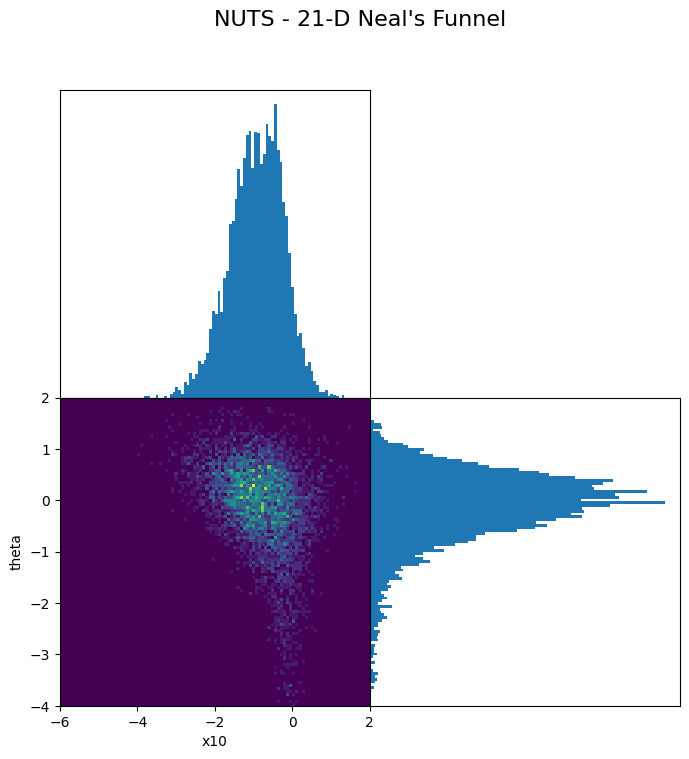

In [ ]:
fig, axis = plt.subplots(2, 2, figsize=(8,8))
fig.suptitle("NUTS - 21-D Neal's Funnel", fontsize=16)

fig.delaxes(axis[1,2])
fig.subplots_adjust(hspace=0)
fig.subplots_adjust(wspace=0)

axis[1,1].hist(x10_nuts, bins=100, range=[-6,2])
axis[1,1].set_yticks([])

axis[2,2].hist(theta_nuts, bins=100, orientation="horizontal", range=[-4, 2])
axis[2,2].set_xticks([])
axis[2,2].set_yticks([])

axis[2,1].hist2d(x10_nuts, theta_nuts, bins=100, range=[[-6,2],[-4, 2]])
axis[2,1].set_xlabel("x10")
axis[2,1].set_ylabel("theta");

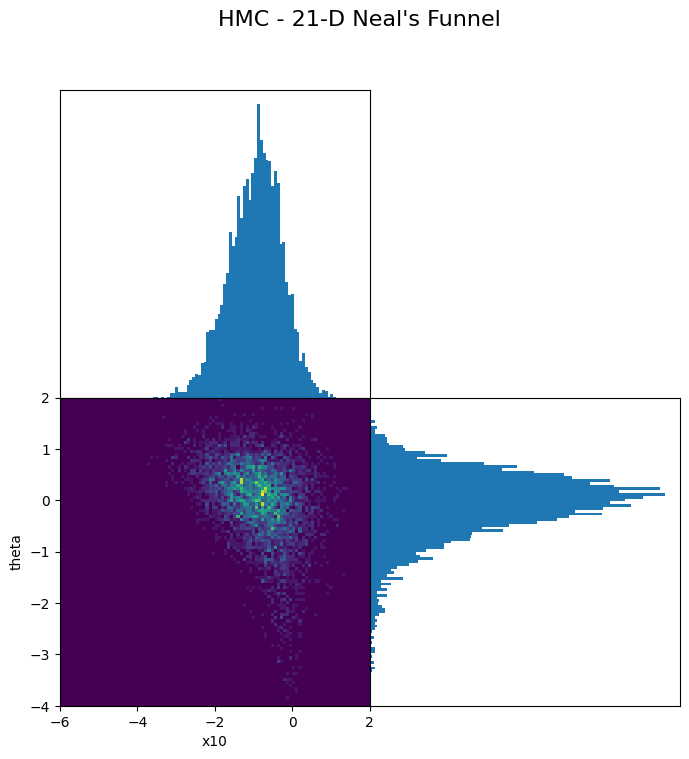

In [ ]:
fig, axis = plt.subplots(2, 2, figsize=(8,8))
fig.suptitle("HMC - 21-D Neal's Funnel", fontsize=16)

fig.delaxes(axis[1,2])
fig.subplots_adjust(hspace=0)
fig.subplots_adjust(wspace=0)

axis[1,1].hist(x10_hmc, bins=100, range=[-6,2])
axis[1,1].set_yticks([])

axis[2,2].hist(theta_hmc, bins=100, orientation="horizontal", range=[-4, 2])
axis[2,2].set_xticks([])
axis[2,2].set_yticks([])

axis[2,1].hist2d(x10_hmc, theta_hmc, bins=100, range=[[-6,2],[-4, 2]])
axis[2,1].set_xlabel("x10")
axis[2,1].set_ylabel("theta");

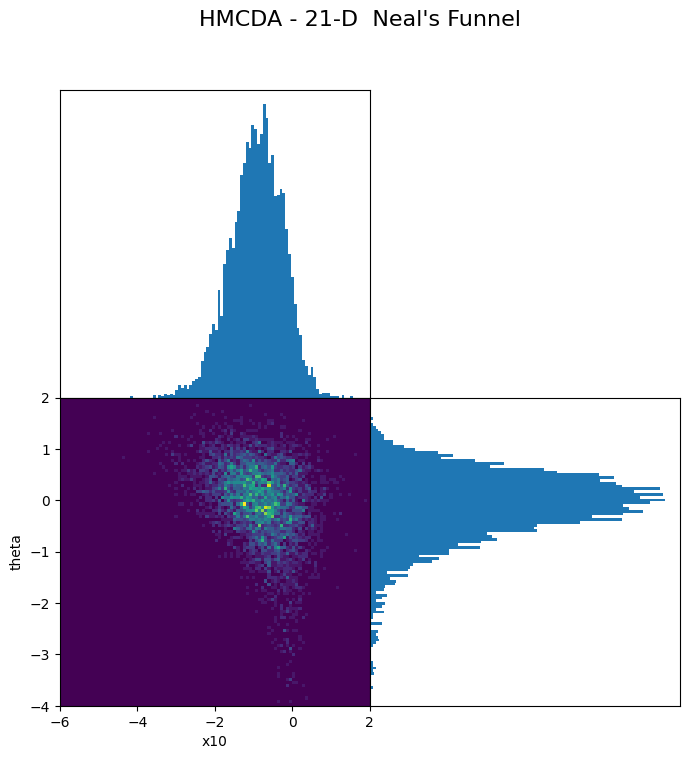

In [ ]:
fig, axis = plt.subplots(2, 2, figsize=(8,8))
fig.suptitle("HMCDA - 21-D  Neal's Funnel", fontsize=16)

fig.delaxes(axis[1,2])
fig.subplots_adjust(hspace=0)
fig.subplots_adjust(wspace=0)

axis[1,1].hist(x10_hmcda, bins=100, range=[-6,2])
axis[1,1].set_yticks([])

axis[2,2].hist(theta_hmcda, bins=100, orientation="horizontal", range=[-4, 2])
axis[2,2].set_xticks([])
axis[2,2].set_yticks([])

axis[2,1].hist2d(x10_hmcda, theta_hmcda, bins=100, range=[[-6,2],[-4, 2]])
axis[2,1].set_xlabel("x10")
axis[2,1].set_ylabel("theta");